## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!gdown --id 1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K

Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints-2021-05-14_08_16_.json
100% 83.4M/83.4M [00:00<00:00, 193MB/s]


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file 
with open("/content/complaints-2021-05-14_08_16_.json") as f:  
# returns JSON object as  
# a dictionary 
  data = json.load(f)
complaint_data=pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
print(complaint_data.shape)
complaint_data.info()

(78313, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 n

In [6]:
#print the column names
print(complaint_data.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [7]:

complaint_data.columns = [re.sub("^_(source.)?", "", column_name) for column_name in complaint_data.columns]

complaint_data.rename(columns={"complaint_what_happened":"complaints"},inplace=True)
print(complaint_data.shape)
complaint_data.columns

(78313, 22)


Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely', 'complaints',
       'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [8]:
##check columns with blanks
(complaint_data[:] == "").sum()

index                            0
type                             0
id                               0
score                            0
tags                             0
zip_code                         0
complaint_id                     0
issue                            0
date_received                    0
state                            0
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response          0
sub_product                      0
timely                           0
complaints                   57241
sub_issue                        0
consumer_consent_provided        0
dtype: int64

In [9]:
#Assign nan in place of blanks in the complaints column
complaint_data.replace("", np.nan, inplace=True)
print(complaint_data.shape)

(78313, 22)


In [10]:
complaint_data.isnull().sum()

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaints                   57241
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [11]:
#Remove all rows where complaints column is nan
print("Data set shape before dropping the complaints column:")
print(complaint_data.shape)
complaint_data.dropna(inplace = True, subset=["complaints"])
print("Data set shape after dropping the complaints column:")
print(complaint_data.shape)
print(complaint_data.info())

Data set shape before dropping the complaints column:
(78313, 22)
Data set shape after dropping the complaints column:
(21072, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [12]:
print(complaint_data["complaints"].dtype)
complaint_data.complaints=complaint_data.complaints.astype(str)
complaint_data["complaints"].dtype

object


dtype('O')

In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleaned(compliant) :
  complaint = compliant.lower()
  complaint = re.sub("\[.*?\]", "", complaint)
  complaint = "".join (char for char in complaint if char not in string.punctuation)
  complaint = re.sub(r'\w*\d\w*', "", complaint).strip()
  return complaint

complaints_final = complaint_data["complaints"].apply(cleaned)
complaints_final

1        good morning my name is xxxx xxxx and i apprec...
2        i upgraded my xxxx xxxx card in  and was told ...
10       chase card was reported on  however fraudulent...
11       on  while trying to book a xxxx  xxxx  ticket ...
14       my grand son give me check for  i deposit it i...
                               ...                        
78303    after being a chase card customer for well ove...
78309    on wednesday xxxxxxxx i called chas my xxxx xx...
78310    i am not familiar with xxxx pay and did not un...
78311    i have had flawless credit for  yrs ive had ch...
78312    roughly  years ago i closed out my accounts wi...
Name: complaints, Length: 21072, dtype: object

In [14]:
#Write your function to Lemmatize the texts
def lemmatizer(complaint):
  doc = nlp(str(complaint))
  lemma_complaint = " ".join([token.lemma_ for token in doc])
  
  return lemma_complaint

lemma_complaint = complaints_final.apply(lemmatizer)
lemma_complaint

1        good morning -PRON- name be xxxx xxxx and i ap...
2        i upgrade -PRON- xxxx xxxx card in   and be te...
10       chase card be report on   however fraudulent a...
11       on   while try to book a xxxx   xxxx   ticket ...
14       -PRON- grand son give -PRON- check for   i dep...
                               ...                        
78303    after be a chase card customer for well over a...
78309    on wednesday xxxxxxxx i call chas -PRON- xxxx ...
78310    i be not familiar with xxxx pay and do not und...
78311    i have have flawless credit for   yrs -PRON- h...
78312    roughly   year ago i close out -PRON- account ...
Name: complaints, Length: 21072, dtype: object

In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
pd.set_option("max_colwidth", None)

df_clean = pd.DataFrame({"complaints" : complaints_final, "lemmatized_complaints" : lemma_complaint})


In [16]:
df_clean

,complaints,lemmatized_complaints
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in -PRON- information for the offer and within less than a minute be notify via the screen that a decision could not be make i immediately contact xxxx and be refer to chase bank i then immediately contact chase bank within no more than of get the notification on the screen and i be tell by the chase representative i spea

In [17]:
# #Write your function to extract the POS tags 
# def lemmatizer_with_postag(complaint):
#   doc = nlp(str(complaint))
#   pos_filter = " ".join([token.lemma_ for token in doc if token.pos_ == "NOUN"])
#   return pos_filter

# lemma_pos = complaints_final.apply(lemmatizer_with_postag)

In [18]:
#Write your function to extract the POS tags 
from textblob import TextBlob
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


def lemmatizer_with_postag(complaint):
   blob = TextBlob(complaint)
   return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

lemma_pos = lemma_complaint.apply(lemmatizer_with_postag)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [19]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
pd.set_option("max_colwidth", None)
df_clean = pd.DataFrame({"raw_complaints" : complaints_final, "lemmatized_complaints" : lemma_complaint, "pos_filtered_complaints" : lemma_pos})
df_clean

,raw_complaints,lemmatized_complaints,pos_filtered_complaints
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come across an 

In [20]:
df_clean.shape

(21072, 3)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length

#### Find the top 40 words by frequency among all the articles after processing the text.

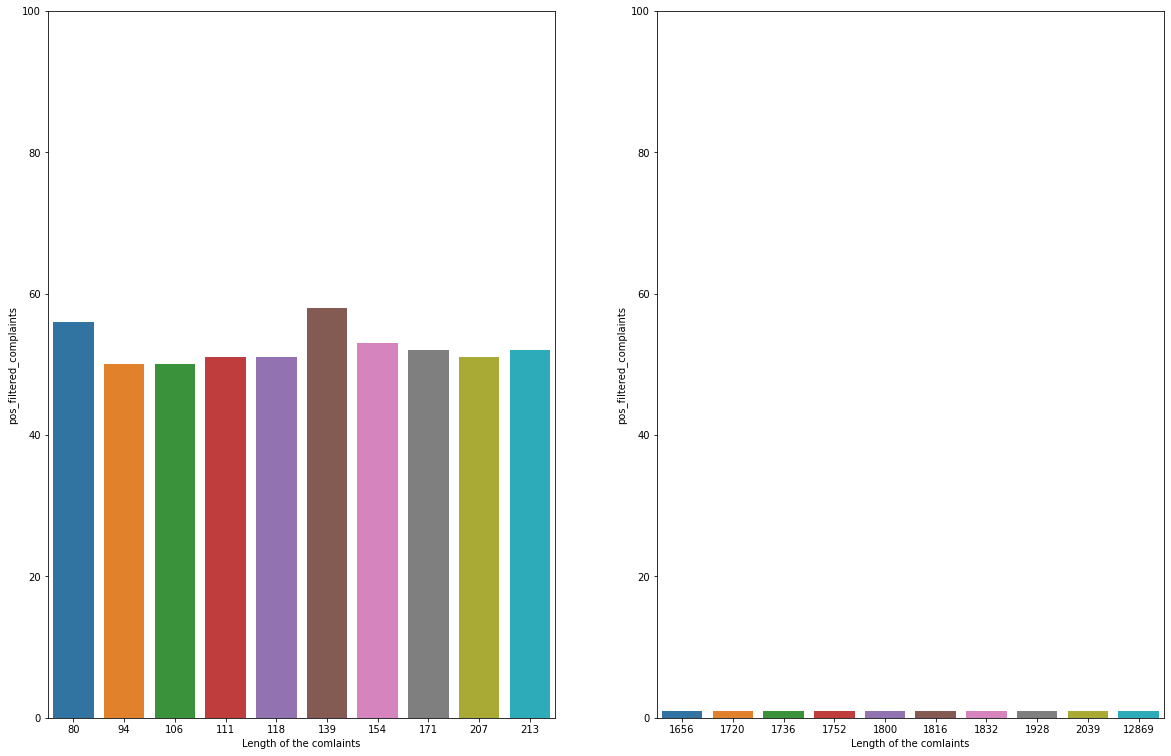

In [22]:
# Write your code here to visualise the data according to the 'Complaint' character length
len_complaints = df_clean["pos_filtered_complaints"].apply(len).value_counts()
plt.figure(figsize = (20, 13))
plt.subplot(1, 2, 1)
plt.ylim((0, 100))
plt.xlabel("Length of the comlaints")
plt.ylabel("No of complaints")
sns.barplot(x = len_complaints.index[:10], y = len_complaints[:10])
plt.subplot(1, 2, 2)
plt.ylim((0, 100))
plt.xlabel("Length of the comlaints")
plt.ylabel("No of complaints")
sns.barplot(x = len_complaints.index[-10:], y = len_complaints[-10:])
plt.show()

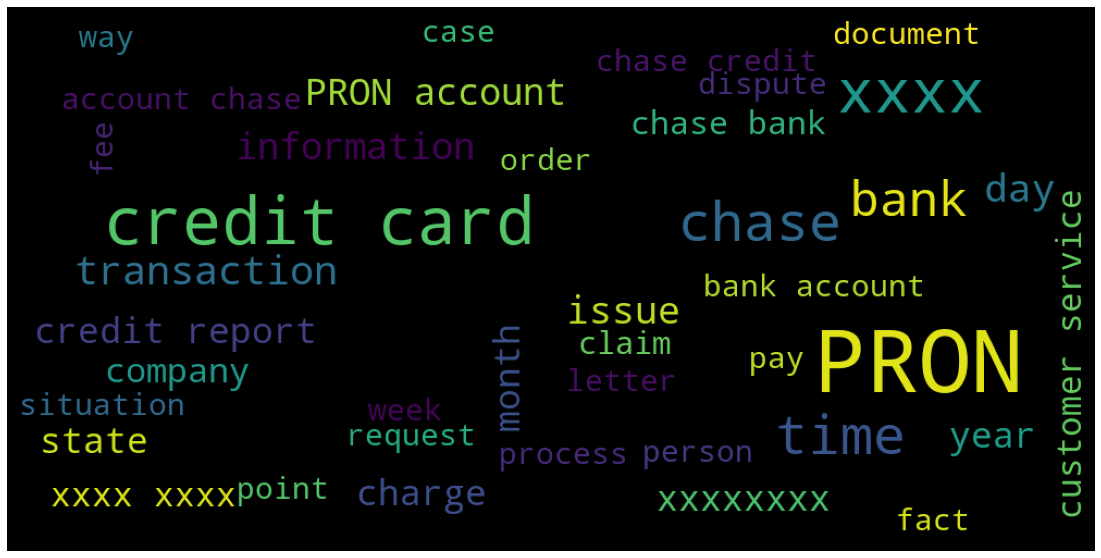

In [23]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
!pip install wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'black', width = 1000, height = 500,
                      colormap = 'viridis', max_words = 40, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 100).generate("".join(df_clean["pos_filtered_complaints"]))
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [24]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords2 = stopwords.words('english')
c_vec = CountVectorizer(stop_words=stopwords2, ngram_range=(1,1))
# matrix of ngrams
ngrams = c_vec.fit_transform(complaint_data['complaints'])
# count frequency of ngrams
count_values = sum(ngrams).data
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'unigram'})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
#Print the top 10 words in the unigram frequency
df_ngram.head(10)

,frequency,unigram
0,228998,jammed
1,80810,jag
2,77015,itunes
3,42745,iunfortunately
4,32806,jawline
5,30482,itenerary
6,26941,itwas
7,26760,jacuzzi
8,20364,itll
9,16383,itshouldalsobe


In [26]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn.model_selection import train_test_split, GridSearchCV
#from wordcloud import WordCloud, stopwords
nltk.download('stopwords')
stopwords2 = stopwords.words('english')
c_vec = CountVectorizer(stop_words=stopwords2, ngram_range=(2,2))
# matrix of ngrams
ngrams = c_vec.fit_transform(complaint_data['complaints'])
# count frequency of ngrams
count_values = sum(ngrams).data
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram'})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
#Print the top 10 words in the bigram frequency
df_ngram.head(10)

,frequency,bigram
0,89040,last old
1,38191,last line
2,28157,last jp
3,12708,last number
4,10938,largest depositor
5,5786,last job
6,4835,last return
7,3659,last remaining
8,3568,large serve
9,3246,last chance


In [28]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn.model_selection import train_test_split, GridSearchCV
#from wordcloud import WordCloud, stopwords
nltk.download('stopwords')
stopwords2 = stopwords.words('english')
c_vec = CountVectorizer(stop_words=stopwords2, ngram_range=(3,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(complaint_data['complaints'])
# count frequency of ngrams
count_values = sum(ngrams).data
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'trigram'})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
#Print the top 10 words in the trigram frequency
df_ngram.head(10)

,frequency,trigram
0,41083,later chased locked
1,27747,later chase releases
2,5779,later chase reject
3,2853,lawyers certified teller
4,2627,later responsible process
5,2452,later chase released
6,2229,later looking refinance
7,2127,later claims dept
8,1851,later chase told
9,1821,later attorney called


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [30]:
df_clean.isnull().sum()

raw_complaints             0
lemmatized_complaints      0
pos_filtered_complaints    0
dtype: int64

In [31]:
df_clean['Complaint_clean'] = df_clean['pos_filtered_complaints'].str.replace('-PRON-', '')

In [32]:
df_clean.shape

(21072, 4)

In [33]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [34]:
df_clean.shape

(21072, 4)

In [35]:
#All masked texts has been removed
df_clean

,raw_complaints,lemmatized_complaints,pos_filtered_complaints,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase re

In [36]:
df_clean.isnull().sum()

raw_complaints             0
lemmatized_complaints      0
pos_filtered_complaints    0
Complaint_clean            0
dtype: int64

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [37]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [38]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [39]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [40]:
#Load your nmf_model with the n_components i.e 5
num_topics =5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40)

In [41]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



7402

In [42]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



THE TOP 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'fund', 'chase', 'money', 'check', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['car', 'year', 'chase', 'account', 'credit', 'date', 'auto', 'time', 'pay', 'day', 'fee', 'statement', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['company', 'statement', 'time', 'refund', 'service', 'fraud', 'claim', 'purchase', 'merchant', 'dispute', 'transaction', 'chase', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan']




In [43]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [44]:
df_clean.shape

(21072, 4)

In [45]:
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2])

In [46]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [47]:
df_clean.shape

(21072, 5)

In [48]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')


,raw_complaints,lemmatized_complaints,pos_filtered_complaints,Complaint_clean,Topic
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to speek with -PRON- grand son check be clear money be take by -PRON- chase bank refuse to pay -PRON- -PRON- money -PRON- grand son call chase time -PRON- tell -PRON- i should call not -PRON- to verify the check owner -PRON- be out the country most the time date happen check number xxxx claim number be xxxx with chase,son check deposit -PRON- chase account fund chase bank account money son check money chase bank refuse money son call chase time i check owner country time date check number claim number chase,son check deposit chase account fund chase bank account money son check money chase bank refuse money son call chase time i check owner country time date check number claim number chase,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,with out notice jp morgan chase restrict -PRON- account by -PRON- debit card tuesday on thursday i go into a branch after be advise by a customer service representative that -PRON- account would actually be close i go into the branch to see how i can remove the fund that be in there currently in as well as if -PRON- direct deposit from -PRON

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [49]:
df_clean.shape

(21072, 5)

In [50]:
df_clean.isnull().sum()

raw_complaints             0
lemmatized_complaints      0
pos_filtered_complaints    0
Complaint_clean            0
Topic                      0
dtype: int64

In [51]:
#Create the dictionary again of Topic names and Topics

# Topic_names = {"Bank Account services":0,"Theft/Dispute Reporting":1,"Others":2,"Credit card or prepaid card":3,"Mortgage/Loan":4}

# Topic_names = {0:"Bank Account services",1:"Theft/Dispute Reporting",2:"Others",3:"Credit card or prepaid card",4:"Mortgage/Loan"} 

# Topic_names = {0:"Mortgage/Loan",1:"Credit card or prepaid card", 2:"Others",3:"Theft/Dispute Reporting",4:"Bank Account services"}

Topic_names = {0:"Bank Account services",1:"Credit card or prepaid card", 2:"Others",3:"Theft/Dispute Reporting",4:"Mortgage/Loan"}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [52]:
df_clean.head(5)

,raw_complaints,lemmatized_complaints,pos_filtered_complaints,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date consent recording agent,Credit card or prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to 

In [53]:
df_clean.shape

(21072, 5)

In [54]:
df_dc=df_clean.groupby('Topic').head(5)
df_dc.sort_values('Topic')

,raw_complaints,lemmatized_complaints,pos_filtered_complaints,Complaint_clean,Topic
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to speek with -PRON- grand son check be clear money be take by -PRON- chase bank refuse to pay -PRON- -PRON- money -PRON- grand son call chase time -PRON- tell -PRON- i should call not -PRON- to verify the check owner -PRON- be out the country most the time date happen check number xxxx claim number be xxxx with chase,son check deposit -PRON- chase account fund chase bank account money son check money chase bank refuse money son call chase time i check owner country time date check number claim number chase,son check deposit chase account fund chase bank account money son check money chase bank refuse money son call chase time i check owner country time date check number claim number chase,Bank Account services
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,with out notice jp morgan chase restrict -PRON- account by -PRON- debit card tuesday on thursday i go into a branch after be advise by a customer service representative that -PRON- account would actually be close i go into the branch to see how i can remove the fund that be in there currently in as well as if -PRON- direc

In [55]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["raw_complaints","Topic"]]

In [56]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [57]:
# Topic_names = {"Mortgage/Loan":0,"Credit card or prepaid card":1,"Others":2,"Theft/Dispute Reporting":3,"Bank Account services":4}

Topic_names = {"Bank Account services":0,"Credit card or prepaid card":1,"Others":2,"Theft/Dispute Reporting":3,"Mortgage/Loan":4}
training_data['Topic'] = training_data['Topic'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
training_data.head(5)

,raw_complaints,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0


In [59]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer


countVect = CountVectorizer()
X_train_counts = countVect.fit_transform(training_data.raw_complaints)



In [60]:
from sklearn.feature_extraction.text import TfidfTransformer


tfidfTransf = TfidfTransformer()
X_train_tfidf = tfidfTransf.fit_transform(X_train_counts)



You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [61]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
LRMod = LogisticRegression(solver='lbfgs', max_iter=1000 ,random_state=0).fit(X_train, y_train)





In [62]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer



target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft/Dispute Reporting","Mortgage/Loan"]

docs_new = "chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant"
docs_new = [docs_new]


X_new_counts = countVect.transform(docs_new)
X_new_tfidf = tfidfTransf.transform(X_new_counts)
predicted = LRMod.predict(X_new_tfidf)

print(target_names[predicted[0]])


Credit card or prepaid card


In [63]:
predicted = LRMod.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Credit card or prepaid card  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Others  -  Others
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/Dispute

In [64]:

from sklearn.metrics import classification_report
target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

print(classification_report(y_test, predicted, target_names=target_names))

                             precision    recall  f1-score   support

      Bank Account services       0.92      0.95      0.94      1303
Credit card or prepaid card       0.94      0.93      0.93      1289
              Mortgage/Loan       0.95      0.89      0.92       548
            Theft Reporting       0.91      0.91      0.91      1205
                     Others       0.93      0.94      0.94       923

                   accuracy                           0.93      5268
                  macro avg       0.93      0.92      0.93      5268
               weighted avg       0.93      0.93      0.93      5268



In [65]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
decisionModel = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

In [66]:
target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft/Dispute Reporting","Mortgage/Loan"]

docs_new = "chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant"
docs_new = [docs_new]


X_new_counts = countVect.transform(docs_new)
X_new_tfidf = tfidfTransf.transform(X_new_counts)
predicted = decisionModel.predict(X_new_tfidf)

print(target_names[predicted[0]])

Credit card or prepaid card


In [67]:
predicted = decisionModel.predict(X_test)
resultDM = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Credit card or prepaid card  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Others  -  Others
Bank Account services  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/Dispute Repor

In [68]:
from sklearn.metrics import classification_report
target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]

print(classification_report(y_test, predicted, target_names=target_names))

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.78      0.78      1303
Credit card or prepaid card       0.82      0.80      0.81      1289
              Mortgage/Loan       0.74      0.76      0.75       548
            Theft Reporting       0.72      0.73      0.73      1205
                     Others       0.80      0.81      0.80       923

                   accuracy                           0.78      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



In [69]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier
randomModel = RandomForestClassifier(max_depth=10, random_state=0)
randomModel.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [70]:
target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft/Dispute Reporting","Mortgage/Loan"]

docs_new = "chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant"
docs_new = [docs_new]


X_new_counts = countVect.transform(docs_new)
X_new_tfidf = tfidfTransf.transform(X_new_counts)
predicted = randomModel.predict(X_new_tfidf)

print(target_names[predicted[0]])

Credit card or prepaid card


In [71]:
predicted = randomModel.predict(X_test)
rModelResult = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Credit card or prepaid card  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Credit card or prepaid card  -  Others
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Report

In [72]:
from sklearn.metrics import classification_report


print(classification_report(y_test, predicted, target_names=target_names))

                             precision    recall  f1-score   support

      Bank Account services       0.72      0.90      0.80      1303
Credit card or prepaid card       0.63      0.84      0.72      1289
                     Others       1.00      0.01      0.02       548
    Theft/Dispute Reporting       0.77      0.72      0.75      1205
              Mortgage/Loan       0.86      0.74      0.80       923

                   accuracy                           0.72      5268
                  macro avg       0.80      0.64      0.62      5268
               weighted avg       0.76      0.72      0.69      5268



**From the above inferences, we observed that Logistic Regression model has high precision, f1-score and recall which is 90%.Hence it is the best model than random forest and decision tree models**.